In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from LSTM import *
from LSTMbis import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time
import os

import pdb
import pickle


# For the notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

torch.manual_seed(1)

In [3]:
data_train = {}
data_val = {}
data_test = {}
a = 0
b = 0
c = 0
max_len = 0
for j in range(1,4):
    for i in os.listdir('./final_dataset/train/%s'%j):
        if i.endswith('.txt'):
            a = a+1
            data_train['%s'%a] = pd.read_csv('./final_dataset/train/{}/{}'.format(j,i), header = None, 
                                        names = ['frameNb','id', 'x','y','Vx','Vy'],
                                           delimiter=' ')
            if len(data_train['%s'%a])/20>max_len:
                max_len=int(len(data_train['%s'%a])/20)
    for i in os.listdir('./final_dataset/validation/%s'%j):
        if i.endswith('.txt'):
            b = b+1
            data_val['%s'%b] = pd.read_csv('./final_dataset/validation/{}/{}'.format(j,i), header = None, 
                                        names = ['frameNb','id', 'x','y','Vx','Vy'],
                                           delimiter=' ') 
    for i in os.listdir('./final_dataset/test/%s'%j):
        if i.endswith('.txt'):
            c = c+1
            data_test['%s'%c] = pd.read_csv('./final_dataset/test/{}/{}'.format(j,i), header = None, 
                                        names = ['frameNb','id', 'x','y','Vx','Vy'],
                                           delimiter=' ') 

In [85]:
data_test_3 = {}
c = 0
j=3
for i in os.listdir('./final_dataset/test/%s'%j):
    if i.endswith('.txt'):
        c = c+1
        data_test_3['%s'%c] = pd.read_csv('./final_dataset/test/{}/{}'.format(j,i), header = None, 
                                    names = ['frameNb','id', 'x','y','Vx','Vy'],
                                       delimiter=' ')

In [4]:
max_len

68

## TRAIN SET

In [6]:
a = 0
inputs_train = np.zeros([10,len(data_train),4*max_len])
gt_train = np.zeros([11,len(data_train),4])
in_train_coord = np.zeros([10,len(data_train),2])
gt_train_coord = np.zeros([11,len(data_train),2])

for i in data_train:
    len_d = np.int(len(data_train['%s'%i])/20)
    inputs_train[:,a,:4] = data_train['%s'%i].loc[0:9,'x':'Vy']
    for m in range(10):
        frame = np.array(data_train['%s'%i].loc[m,'frameNb'])  
        for j in range(1,len_d):
            for k in range(20):
                if data_train['%s'%i].loc[j*20+k,'frameNb']==frame:
                    inputs_train[m,a,j*4:(j+1)*4]=data_train['%s'%i].loc[j*20+k,'x':'Vy']
    
    gt_train[:,a,:] = np.array(data_train['%s'%i].loc[9:19,['x','y','Vx','Vy']])
    in_train_coord[:,a,:] = np.array(data_train['%s'%i].loc[0:9,['x','y']])
    gt_train_coord[:,a,:] = np.array(data_train['%s'%i].loc[9:19,['x','y']])
    a +=1


inputs_train = torch.from_numpy(inputs_train).float()
gt_train = torch.from_numpy(gt_train).float()
inputs_train = inputs_train.permute([1,0,2])
gt_train = gt_train.permute([1,0,2])


In [79]:
pickle.dump( inputs_train.numpy(), open( "./import_dataset/train/inputs_train.pkl", "wb" ) )
pickle.dump( gt_train.numpy(), open( "./import_dataset/train/gt_train.pkl", "wb" ) )
pickle.dump( in_train_coord, open( "./import_dataset/train/in_train_coord.pkl", "wb" ) )
pickle.dump( gt_train_coord, open( "./import_dataset/train/gt_train_coord.pkl", "wb" ) )

## VALIDATION SET

In [81]:
a = 0
inputs_validation = np.zeros([10,len(data_val),4*max_len])
gt_validation = np.zeros([11,len(data_val),4])
in_validation_coord = np.zeros([10,len(data_val),2])
gt_validation_coord = np.zeros([11,len(data_val),2])

for i in data_val:
    len_d = np.int(len(data_val['%s'%i])/20)
    inputs_validation[:,a,:4] = data_val['%s'%i].loc[0:9,'x':'Vy']
    for m in range(10):
        frame = np.array(data_val['%s'%i].loc[m,'frameNb'])  
        for j in range(1,len_d):
            for k in range(20):
                if data_val['%s'%i].loc[j*20+k,'frameNb']==frame:
                    inputs_validation[m,a,j*4:(j+1)*4]=data_val['%s'%i].loc[j*20+k,'x':'Vy']
    
    gt_validation[:,a,:] = np.array(data_val['%s'%i].loc[9:19,['x','y','Vx','Vy']])
    in_validation_coord[:,a,:] = np.array(data_val['%s'%i].loc[0:9,['x','y']])
    gt_validation_coord[:,a,:] = np.array(data_val['%s'%i].loc[9:19,['x','y']])
    a +=1


inputs_validation = torch.from_numpy(inputs_validation).float()
gt_validation = torch.from_numpy(gt_validation).float()
inputs_validation = inputs_validation.permute([1,0,2])
gt_validation = gt_validation.permute([1,0,2])


In [82]:
pickle.dump( inputs_validation.numpy(), open( "./import_dataset/validation/inputs_validation.pkl", "wb" ) )
pickle.dump( gt_validation.numpy(), open( "./import_dataset/validation/gt_validation.pkl", "wb" ) )
pickle.dump( in_validation_coord, open( "./import_dataset/validation/in_validation_coord.pkl", "wb" ) )
pickle.dump( gt_validation_coord, open( "./import_dataset/validation/gt_validation_coord.pkl", "wb" ) )

## TEST SET

In [96]:
a = 0
inputs_test_3 = np.zeros([10,len(data_test_3),4*max_len])
gt_test_3 = np.zeros([11,len(data_test_3),4])
in_test_coord_3 = np.zeros([10,len(data_test_3),2])
gt_test_coord_3 = np.zeros([11,len(data_test_3),2])

for i in data_test_3:
    len_d = np.int(len(data_test_3['%s'%i])/20)
    inputs_test_3[:,a,:4] = data_test_3['%s'%i].loc[0:9,'x':'Vy']
    for m in range(10):
        frame = np.array(data_test_3['%s'%i].loc[m,'frameNb'])  
        for j in range(1,len_d):
            for k in range(20):
                if data_test_3['%s'%i].loc[j*20+k,'frameNb']==frame:
                    inputs_test_3[m,a,j*4:(j+1)*4]=data_test_3['%s'%i].loc[j*20+k,'x':'Vy']
    
    gt_test_3[:,a,:] = np.array(data_test_3['%s'%i].loc[9:19,['x','y','Vx','Vy']])
    in_test_coord_3[:,a,:] = np.array(data_test_3['%s'%i].loc[0:9,['x','y']])
    gt_test_coord_3[:,a,:] = np.array(data_test_3['%s'%i].loc[9:19,['x','y']])
    a +=1


inputs_test_3 = torch.from_numpy(inputs_test_3).float()
gt_test_3 = torch.from_numpy(gt_test_3).float()

In [97]:
pickle.dump( inputs_test_3.numpy(), open( "./import_dataset/test/inputs_test_3.pkl", "wb" ) )
pickle.dump( gt_test_3.numpy(), open( "./import_dataset/test/gt_test_3.pkl", "wb" ) )
pickle.dump( in_test_coord_3, open( "./import_dataset/test/in_test_coord_3.pkl", "wb" ) )
pickle.dump( gt_test_coord_3, open( "./import_dataset/test/gt_test_coord_3.pkl", "wb" ) )

In [53]:
from torch import optim

lr = 0.01
lstm = LSTM(4*max_len,4,num_layers=2,hidden_size=128)
optimizer = optim.SGD(lstm.parameters(), lr=lr)
criterion = nn.MSELoss()

In [54]:
traindataset = utils.TensorDataset(inputs_train, gt_train[:,1:,:])
trainloader = utils.DataLoader(traindataset, batch_size=16, shuffle=True)

valdataset = utils.TensorDataset(inputs_validation, gt_validation[:,1:,:])
valloader = utils.DataLoader(valdataset, batch_size=16, shuffle=True)

epochs = 50
steps = 0
print_every = 323
running_loss = 0 #### DOD

loss_train = []
loss_val = []
for e in range(epochs):
    start = time.time()
    total_train_loss=0
    steps_bis = 0
    if (e+1)%10==0:
        lr /= 5
        optimizer = optim.SGD(lstm.parameters(), lr=lr)

    for train_coord, ground_tru in iter(trainloader):
        steps += 1
        steps_bis+=1
        
        train_coord = train_coord.permute([1,0,2])
        ground_tru = ground_tru.permute([1,0,2])

        in_train = Variable(train_coord)
        targets = Variable(ground_tru)
        optimizer.zero_grad()
        #print(in_train.shape)
        #print(targets.shape)
        out = lstm.forward(in_train)
        out_bis = out[:,:,0:2].clone()
        #print(out_bis.shape)    
        for i in range(10):
            if i == 0:
                out_bis[i, :, 0:2] = in_train[-1, :, 0:2] + out[i, :, 2:]*0.4
            else:
                out_bis[i, :, 0:2] = out[i - 1, :, 0:2] + out[i, :, 2:]*0.4
        #pdb.set_trace()
        loss1 = (criterion(out[:,:,0:2], targets[:,:,0:2]))
        loss2 = (criterion(out[:,:,2:], targets[:,:,2:]))
        loss3 = criterion(out_bis, targets[:,:,0:2])
        loss4 = 5*criterion(out[0,:,2:], targets[0,:,2:])
                                #+ 10*criterion(out_bis[-1,:,:], targets[-1,:,0:2]) 
                                #+ 10*criterion(out_bis[0,:,:], targets[0,:,0:2]))
        loss1.backward(retain_graph=True)
        loss2.backward(retain_graph=True)
        loss3.backward(retain_graph=True)
        loss4.backward()
        optimizer.step()
        
        running_loss += (loss1+loss2+loss3+loss4).data[0]
        total_train_loss += (loss1+loss2+loss3+loss4).data[0]
    
        if steps % print_every == 0:
                stop = time.time()
                val_loss=0
                for ii, (valcoord, valgt) in enumerate(valloader):
                    inputs = Variable(valcoord, volatile=True)
                    predicted = lstm.predict(inputs)
                    val_loss+= criterion(predicted,valgt).data[0]
                    
                print("Epoch: {}/{}..".format(e+1, epochs),
                  "Validation loss: {:.4f}..".format(val_loss/ii),
                  "Training loss: {:.4f}..".format(running_loss/print_every),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
                loss_val.append(val_loss/ii)
                running_loss = 0
                start = time.time()
    loss_train.append(total_train_loss/steps_bis)

/Users/rodolphefarrando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/rodolphefarrando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/rodolphefarrando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/Users/rodolphefarrando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1/50.. Validation loss: 1.3469.. Training loss: 8.4069.. 0.0838 s/batch
Epoch: 2/50.. Validation loss: 0.7826.. Training loss: 4.0403.. 0.0772 s/batch
Epoch: 3/50.. Validation loss: 0.7379.. Training loss: 3.4448.. 0.0789 s/batch
Epoch: 4/50.. Validation loss: 0.7538.. Training loss: 3.2682.. 0.0867 s/batch
Epoch: 5/50.. Validation loss: 0.6898.. Training loss: 3.1382.. 0.0891 s/batch
Epoch: 6/50.. Validation loss: 0.6927.. Training loss: 2.9867.. 0.0903 s/batch
Epoch: 7/50.. Validation loss: 0.6755.. Training loss: 2.8984.. 0.0736 s/batch
Epoch: 8/50.. Validation loss: 0.6303.. Training loss: 2.7861.. 0.0699 s/batch
Epoch: 9/50.. Validation loss: 0.6164.. Training loss: 2.6591.. 0.0691 s/batch
Epoch: 10/50.. Validation loss: 0.5986.. Training loss: 2.4614.. 0.0920 s/batch
Epoch: 11/50.. Validation loss: 0.5913.. Training loss: 2.4105.. 0.0856 s/batch
Epoch: 12/50.. Validation loss: 0.5715.. Training loss: 2.3545.. 0.0975 s/batch
Epoch: 13/50.. Validation loss: 0.5707.. Training

In [55]:
output_test = lstm.predict(inputs_test)
output_test = output_test.data.numpy()

## Post processing step
Go back to coordinate:
We have Vx and Vy and we want x and y.
$ V = d/t$
$ d = V*t$
Here t = 0.4s between each point.
Start from data at index 9. Then we add d_x and d_y to the last x and y.

In [56]:
output_coord=np.zeros([11,len(data_test),2])
for j in range(11):
    for i in range(len(data_test)):
        if j==0:
            output_coord[j,i,0:2] = in_test_coord[9,i,0:2]
        else:
            output_coord[j,i,0:2] = output_coord[j-1,i,0:2]+output_test[j-1,i,2:]*0.4
        

In [57]:
dist = np.zeros(len(data_test))
for i in range(len(data_test)):
    dist[i] = np.sqrt(sum((gt_test_coord[10,i,:]-output_coord[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground trought and the predicted coordinates is :',final_coord_error.round(3))

The final distance between the ground trought and the predicted coordinates is : 1.402


In [58]:
avr = np.zeros((len(data_test),11))
for i in range(len(data_test)):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord[j,i,:]-output_coord[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground trought and the predicted coordinates is :',average.round(3))

The average error between the ground trought and the predicted coordinates is : 0.725


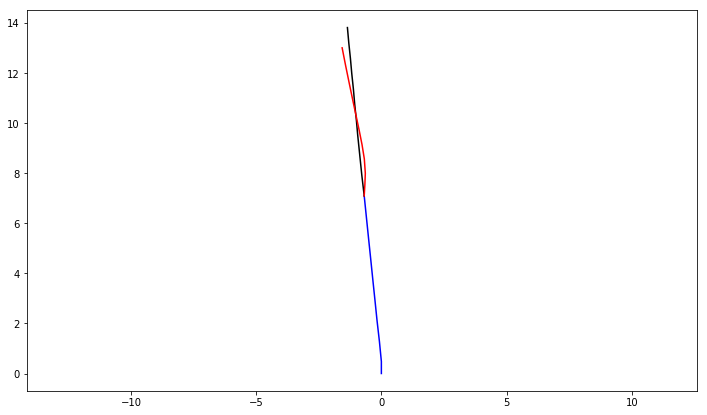

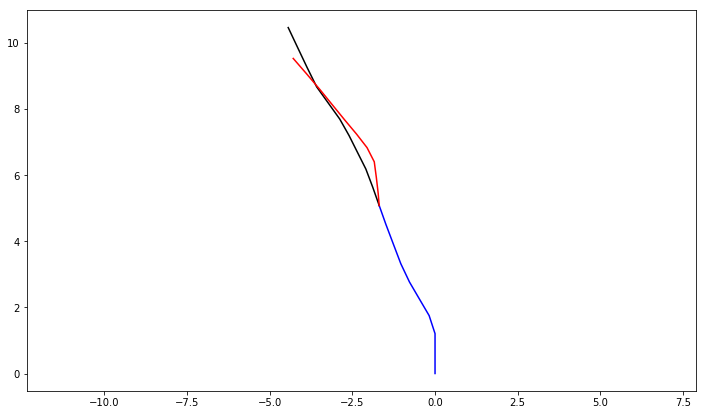

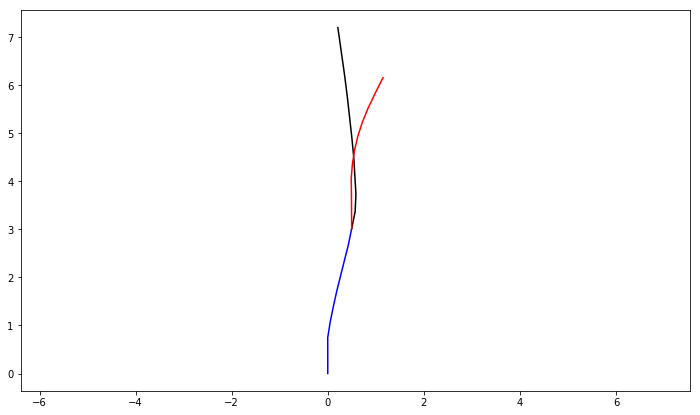

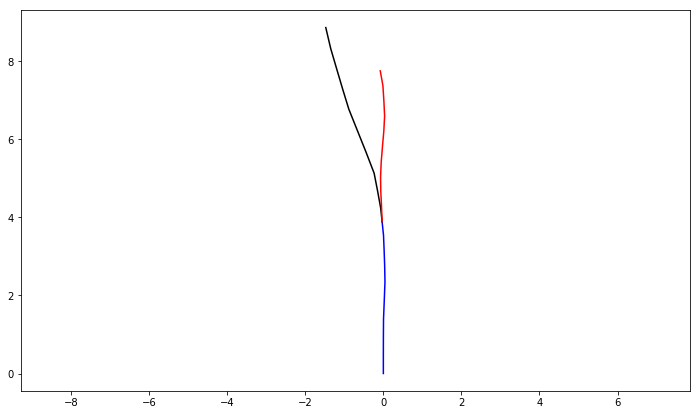

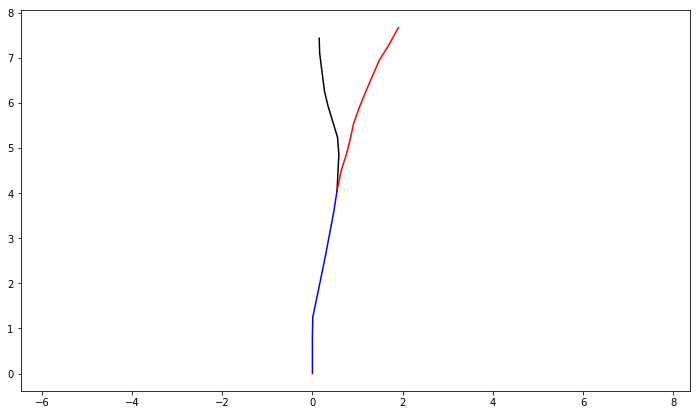

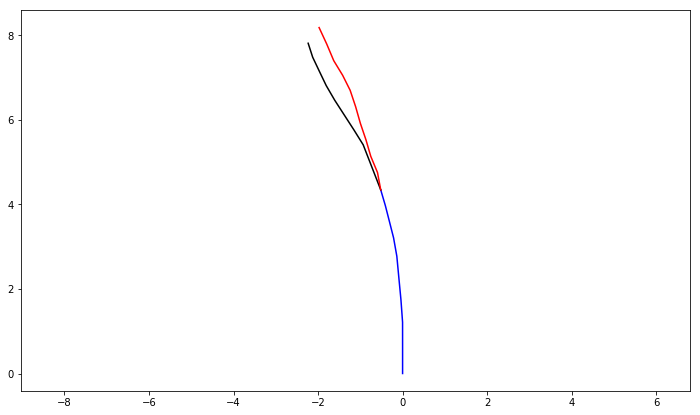

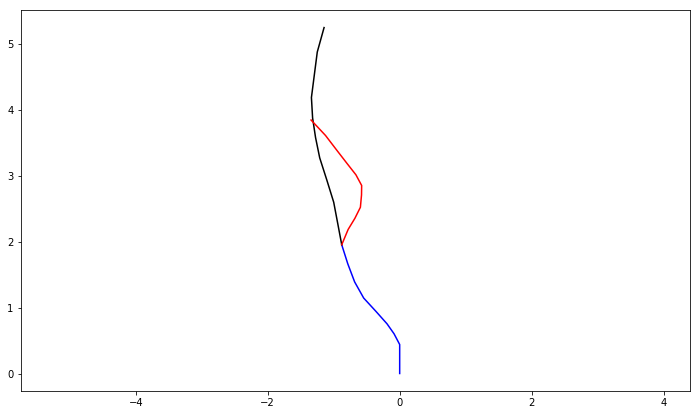

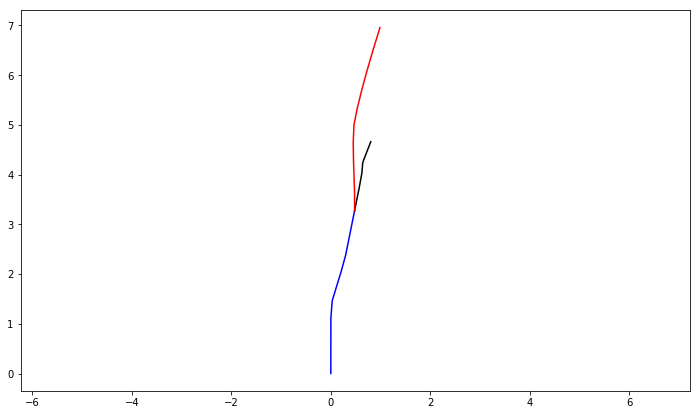

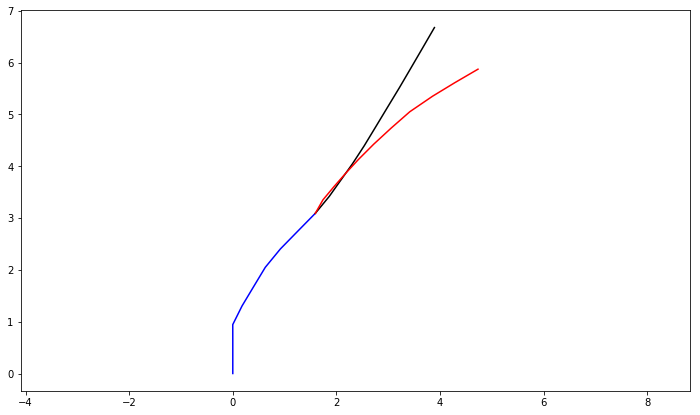

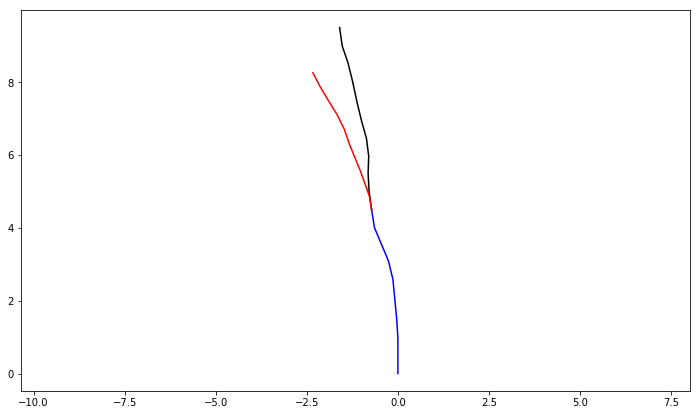

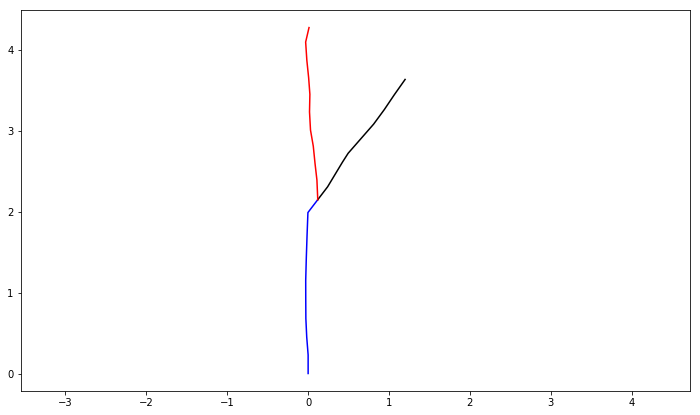

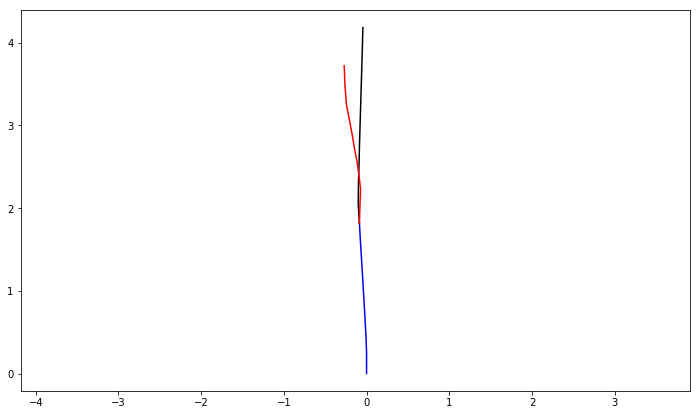

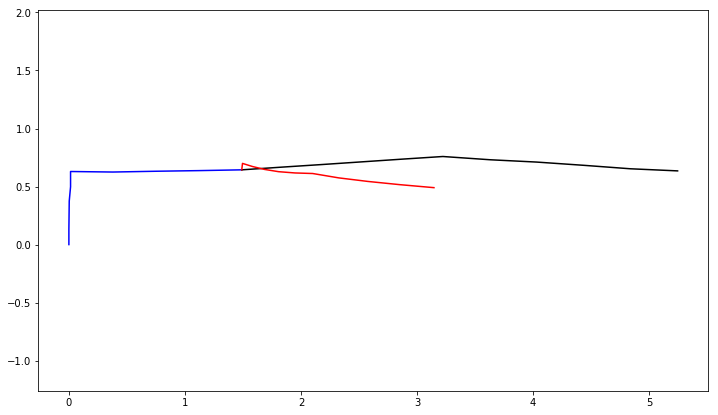

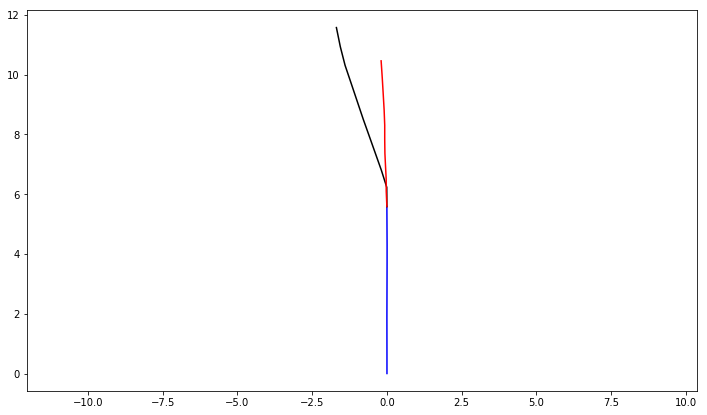

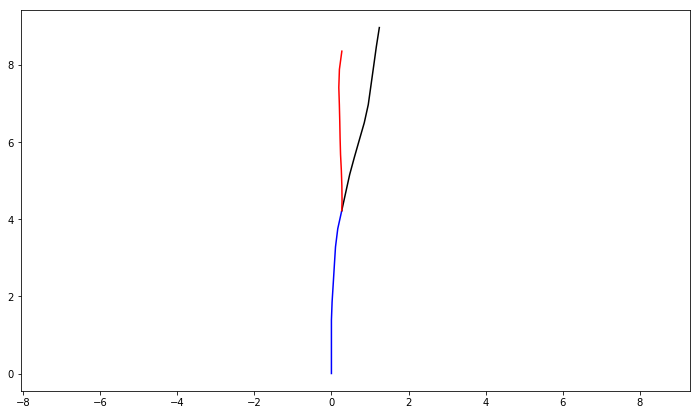

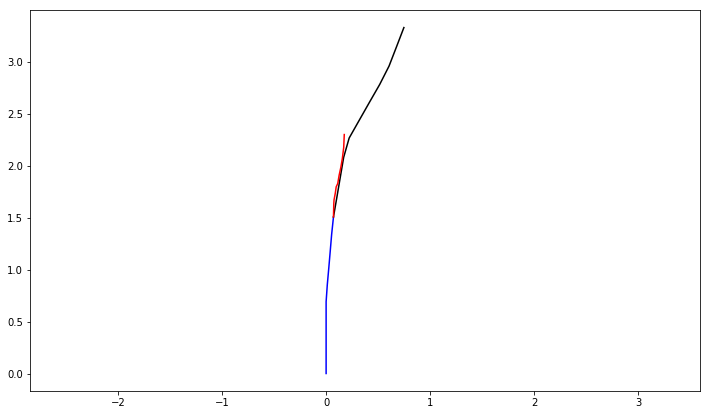

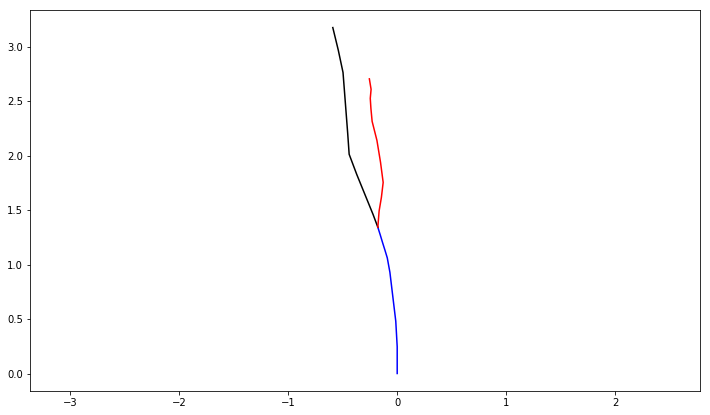

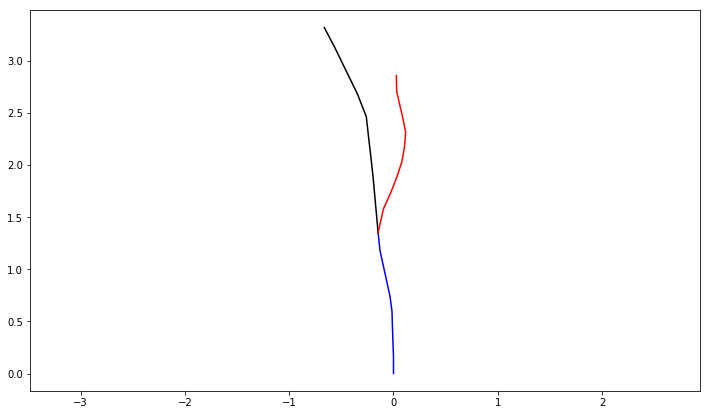

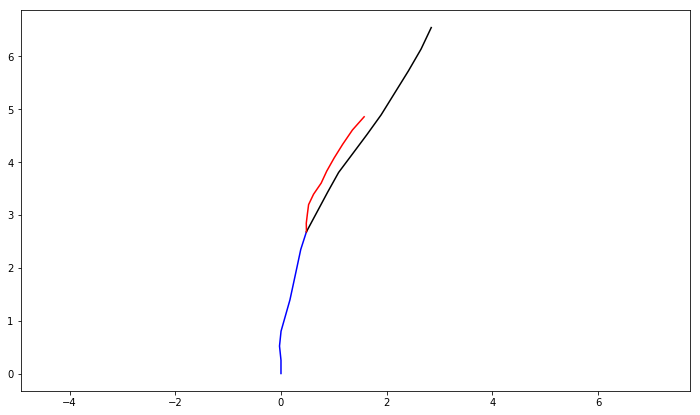

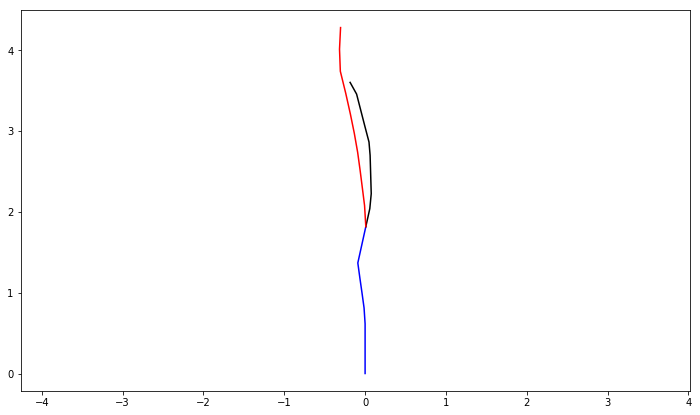

In [59]:
for i in range(20):
    plt.figure(figsize=(12, 7))

    plt.plot(in_test_coord[:,(i*20)+800,0],in_test_coord[:,i*20+800,1],c='b')
    plt.plot(gt_test_coord[:,i*20+800,0],gt_test_coord[:,i*20+800,1],c='k')
    plt.plot(output_coord[:,i*20+800,0],output_coord[:,i*20+800,1],c='r')
    plt.axis('equal')

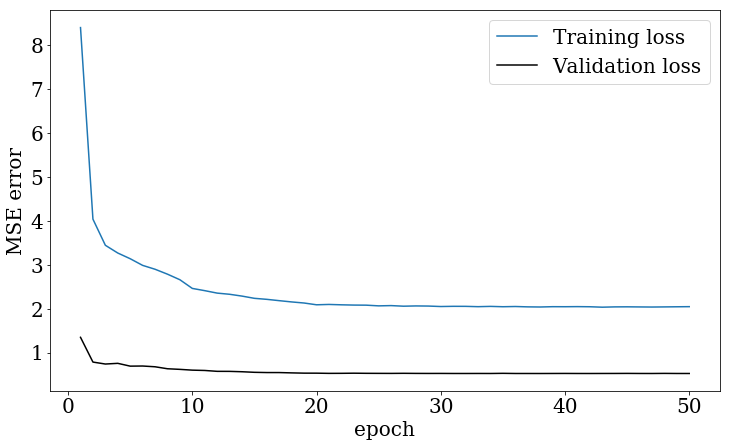

In [110]:
epoch = np.arange(1,epochs+1)
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

plt.plot(epoch,loss_train,label='Training loss')
plt.plot(epoch,loss_val,c='k',label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('MSE error')
plt.legend()

In [112]:
epoch = np.arange(1,epochs+1,0.5)
epoch

array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
        6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5,
       12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. ,
       17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5,
       23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5, 28. ,
       28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5, 33. , 33.5,
       34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. , 38.5, 39. ,
       39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5, 44. , 44.5,
       45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. , 49.5, 50. ,
       50.5])

In [102]:
epoch

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])